In [57]:
import os

import numpy as np
import matplotlib.pyplot as plt

from ase.utils.forcecurve import fit_images
from scipy.interpolate import interp1d

from ase.io import read
from ase.neb import NEB


def plot_neb(images, ax=None, label="", forces_only=False, show=True, symmetrize=False):
    
    if ax is None:
        fig, ax = plt.subplots()
    
    force_fit = fit_images(images)
    
    if forces_only:
        s, E, _ = NEB(images).integrate_forces()
        if symmetrize:
            E = 0.5 * (E + E[::-1])
            E -= E.min()
        
        fitted_E = interp1d(s, E)
        ax.scatter(force_fit.path / force_fit.path[-1], 
                   fitted_E(force_fit.path / force_fit.path[-1]),
                   marker="x")
        ax.plot(s, E, "--")
    else:
        ax.scatter(force_fit.path / force_fit.path[-1], force_fit.energies)
        ax.plot(force_fit.fit_path / force_fit.path[-1], force_fit.fit_energies)

    color = ax.get_lines()[-1].get_color()
    
    if forces_only:
        handle, = ax.plot([], [], "--x", color=color, label=label)
    else:
        handle, = ax.plot([], [], "-o", color=color, label=label)
        
    if show:
        ax.legend()
        ax.set_ylabel("Energy (eV)")
        ax.set_xlabel("Normalised NEB path")
    else:
        return handle
    
def plot_dislo_barriers(dislocation_name="Screw", potential_label="Lam0_500_LamS_1", ax=None, plot_all=True, joint=False, 
                        xyz_folder="../tests", database_label=""):
    
    if dislocation_name not in ["Screw", "Junction100", "Junction110"]:
        raise RuntimeError("Wrong dislocation label!")
    
    if ax is None:
        fig, ax = plt.subplots()
    
    plot_neb(LML_images[dislocation_name], label="Original LML", ax=ax)
    plot_neb(qmml_images[dislocation_name], label="QM/ML", forces_only=True, symmetrize=True, ax=ax)
    
    xyz_labels = {"Screw": "screw",
                  "Junction100": "edge100",
                  "Junction110": "edge100110"}
                         
    if plot_all and not joint:
        for label in xyz_labels:
            images = read(os.path.join(xyz_folder, f"qSNAP{label}{database_label}_{potential_label}_glide_{xyz_labels[dislocation_name]}_images.xyz"),
                         index=":")
            plot_neb(images, label=f"{label} QML", ax=ax)
    elif plot_all and joint:
        images = read(os.path.join(xyz_folder, f"qSNAP{joint}{database_label}_{potential_label}_glide_{xyz_labels[dislocation_name]}_images.xyz"),
                         index=":")
        plot_neb(images, label=f"{joint} QML", ax=ax)
    else:   # plot only bes fit
        images = read(os.path.join(xyz_folder, f"qSNAP{dislocation_name}{database_label}_{potential_label}_glide_{xyz_labels[dislocation_name]}_images.xyz"),
                     index=":")
        plot_neb(images, label=f"{dislocation_name} LML", ax=ax)

    ax.set_title(f"{dislocation_name} glide")

def plot_potential_results(potential_label="Lam0_500_LamS_1",  
                           plot_all=True, joint=False, xyz_folder="../tests", database_label="", axes=None):
    show=False
    if axes is None:
        fig, axes = plt.subplots(figsize=(20, 6), ncols=3)
        show = True
    
    for dislocation_name, ax in zip(["Junction100", "Junction110", "Screw"], axes):
        plot_dislo_barriers(dislocation_name=dislocation_name, ax=ax, potential_label=potential_label, plot_all=plot_all, joint=joint,
                            xyz_folder=xyz_folder, database_label=database_label)
    
    if show:
        fig.suptitle(f"{potential_label} {database_label} potentials")
        return fig

In [2]:
LML_images = {}
qmml_images = {}

LML_images["Junction110"] = read("../data_files/ML_glide_images/LML_glide_edge100110_images.xyz", index=":")
qmml_images["Junction110"] = read("../data_files/QMML_glide_images/edge100110_vasp_LML_6_10_007.xyz", index=":")

LML_images["Junction100"] = read("../data_files/ML_glide_images/LML_glide_edge100_images.xyz", index=":")
qmml_images["Junction100"] = read("../data_files/QMML_glide_images/edge100_vasp_LML_6_10_019.xyz", index=":")

LML_images["Screw"] = read("../data_files/ML_glide_images/LML_glide_screw_images.xyz", index=":")
qmml_images["Screw"] = read("../data_files/QMML_glide_images/screw_vasp_LML_6_12_004.xyz", index=":")



# All potentials and all dislocations

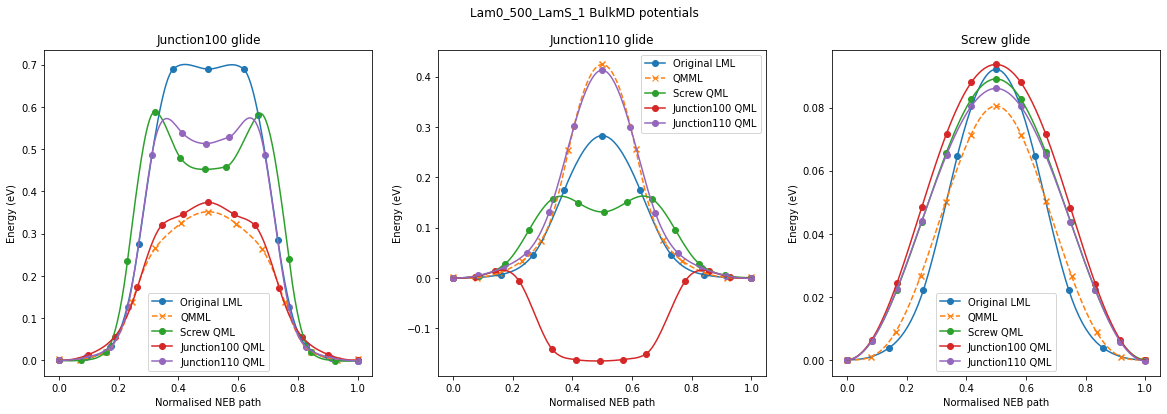

In [22]:
fig = plot_potential_results(potential_label="Lam0_500_LamS_1", 
                             xyz_folder="../data_files/ML_glide_images/", database_label="BulkMD")

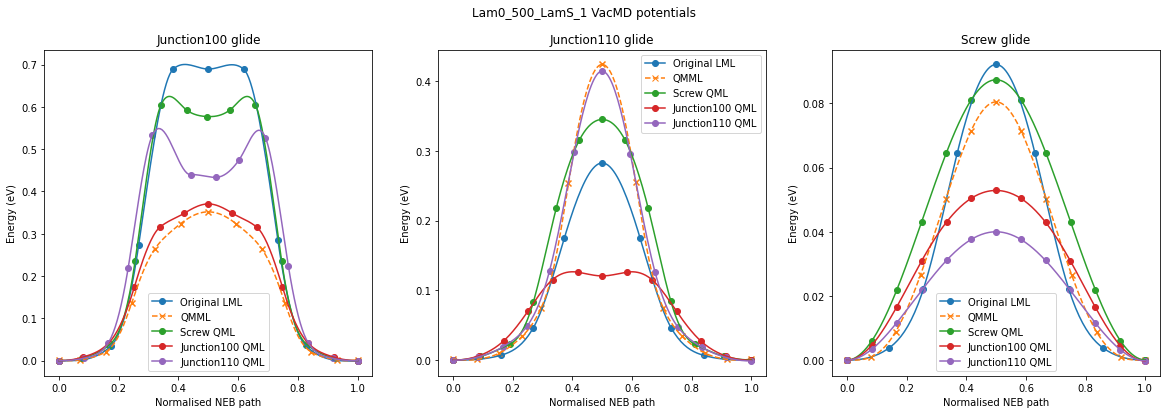

In [23]:
fig = plot_potential_results(potential_label="Lam0_500_LamS_1", 
                             xyz_folder="../data_files/ML_glide_images/", database_label="VacMD")

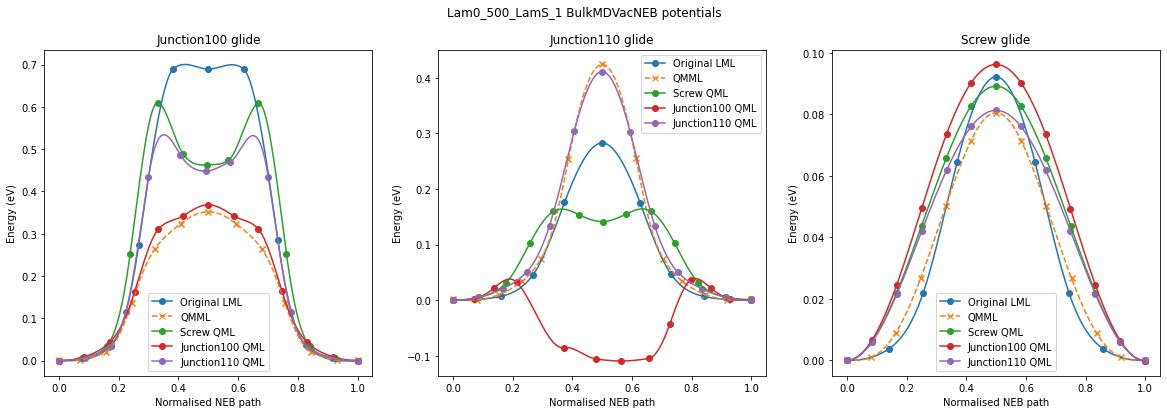

In [24]:
fig = plot_potential_results(potential_label="Lam0_500_LamS_1", 
                             xyz_folder="../data_files/ML_glide_images/", database_label="BulkMDVacNEB")

# Segragation potential

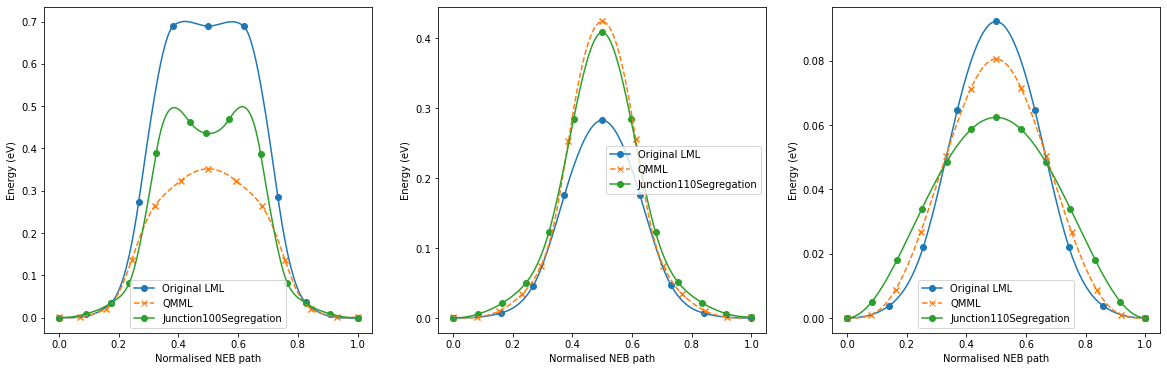

In [76]:
fig, axes = plt.subplots(figsize=(20, 6), ncols=3)

for dislocation_name, ax in zip(["Junction100", "Junction110", "Screw"], axes):
    plot_neb(LML_images[dislocation_name], label="Original LML", ax=ax)
    plot_neb(qmml_images[dislocation_name], label="QMML", forces_only=True, symmetrize=True, ax=ax)
    
seg_junction100_images = read("../data_files/ML_glide_images/qSNAPJunction110BulkMDVacNEBSegregation_Lam0_500_LamS_1_glide_edge100_images.xyz",
                              index=":")

plot_neb(seg_junction100_images, label="Junction100Segregation", ax=axes[0])

seg_junction110_images = read("../data_files/ML_glide_images/qSNAPJunction110BulkMDVacNEBSegregation_Lam0_500_LamS_1_glide_edge100110_images.xyz",
                              index=":")
plot_neb(seg_junction110_images, label="Junction110Segregation", ax=axes[1])

seg_screw_images = read("../data_files/ML_glide_images/qSNAPJunction110BulkMDVacNEBSegregation_Lam0_500_LamS_1_glide_screw_images.xyz",
                              index=":")
plot_neb(seg_screw_images, label="Junction110Segregation", ax=axes[2])

# Supplementary materials figures


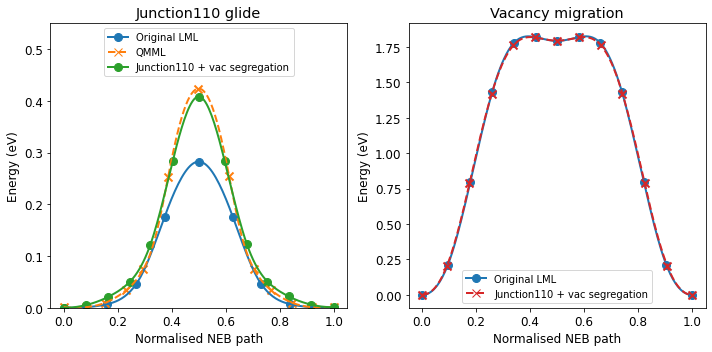

In [152]:
with mpl.rc_context({'lines.linewidth': 2, "font.size": 12, "legend.fontsize": 10, "lines.markersize":8}):
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2)

    dislocation_name = "Junction110"
    plot_neb(LML_images[dislocation_name], label="Original LML", ax=ax1)
    plot_neb(qmml_images[dislocation_name], label="QMML", forces_only=True, symmetrize=True, ax=ax1)

    seg_junction110_images = read("../data_files/ML_glide_images/qSNAPJunction110BulkMDVacNEBSegregation_Lam0_500_LamS_1_glide_edge100110_images.xyz",
                                  index=":")
    plot_neb(seg_junction110_images, label="Junction110 + vac segregation", ax=ax1)
    ax1.set_ylim((0.0, 0.55))
    ax1.set_title("Junction110 glide")

    lml_neb_images = read("../data_files/ML_vac_migration_images/milady_lml_vac_mig_images.xyz", index=":")
    plot_neb(lml_neb_images, label="Original LML", ax=ax2)
    seg_images = read("../data_files/ML_vac_migration_images/qSNAPJunction110BulkMDVacNEBSegregation_Lam0_500_LamS_1_vac_mig_images.xyz", index=":")
    plot_neb(seg_images, ax=ax2, label="Junction110 + vac segregation", forces_only=True)
    ax2.set_title("Vacancy migration")

ax2.collections[1].set_color("C3")
ax2.collections[1].set_zorder(10)
ax2.lines[2].set_color("C3")
handles, labels = ax2.get_legend_handles_labels()
handles[1].set_color("C3")
ax2.legend(handles=handles)
ax1.legend(loc="upper center")
fig.tight_layout()
fig.savefig("SM_junction110Segregation_NEBs.pdf")

In [83]:
def make_figure():
    fig, big_axes = plt.subplots(figsize=(15, 14) , nrows=3, ncols=1, sharey=True) 

    for row, big_ax in enumerate(big_axes, start=1):
        big_ax.set_axis_off()
        # removes the white frame
        big_ax._frameon = False
    
    def make_title(as_label, ah_label):
        return f"LML retrained with " + r"${\bf A}_{\rm S}$: " + as_label + r"; ${\bf A}_{\rm H}:$ " + ah_label
    
    for ax, title in zip(big_axes, [make_title("Bulk MD", "EOS"),
                                    make_title("Vacancy MD", "EOS"),
                                    make_title("Bulk MD", "EOS + Vacancy migration NEB")]):
        ax.set_title(title, fontsize=14, pad=25)


    for i in range(0, 3):
        row = []
        for k in range(1, 4):
            ax = fig.add_subplot(3, 3, k + 3 * i)

    return fig

In [69]:
import matplotlib as mpl

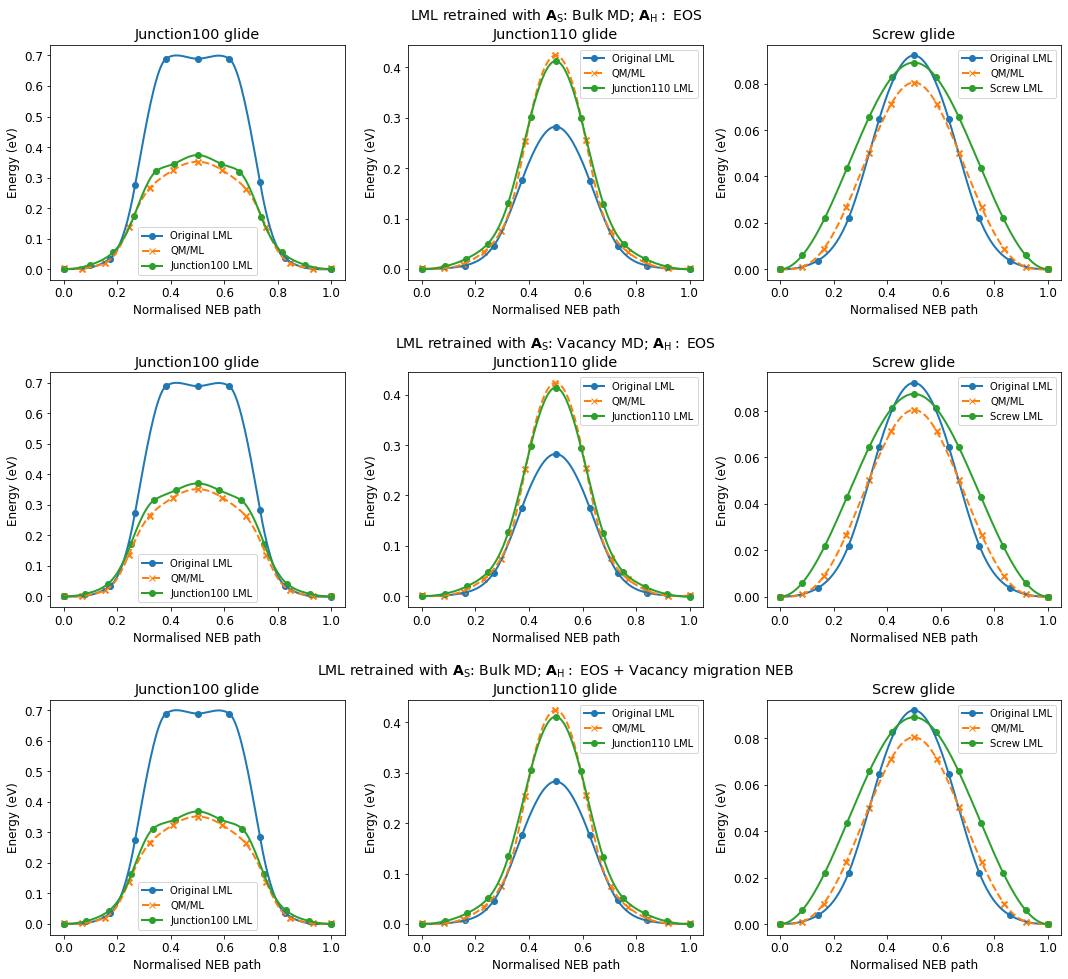

In [70]:
with mpl.rc_context({'lines.linewidth': 2, "font.size": 12, "legend.fontsize": 10}):
    fig = make_figure()
    axes = fig.get_axes()


    plot_potential_results(potential_label="Lam0_500_LamS_1", axes=axes[3:6],
                                 xyz_folder="../data_files/ML_glide_images/", database_label="BulkMD", plot_all=False)

    plot_potential_results(potential_label="Lam0_500_LamS_1", axes=axes[6:9],
                                 xyz_folder="../data_files/ML_glide_images/", database_label="VacMD", plot_all=False)

    plot_potential_results(potential_label="Lam0_500_LamS_1", axes=axes[9:12],
                                 xyz_folder="../data_files/ML_glide_images/", database_label="BulkMDVacNEB", plot_all=False)

    fig.tight_layout(h_pad=.01)

In [71]:
fig.savefig("SM_retrained_glide_barriers.pdf")